In [65]:
##libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt

In [72]:
##read data - biomass, Virginia LTER
df = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_ChristianBlum.csv', skiprows=21)
df = df[df['speciesName'] == 'Spartina alterniflora']
df = df[['EOYBYear', 'collectDate', 'marshName', 'siteName', 'marshRegion', 'monitoringPurpose', 'Transect', 'Replicate', 'speciesName', 'liveMass', 'deadMass', 'totalMass', 'latitude', 'longitude']]
df['collectDate'] = pd.to_datetime(df['collectDate'])

##water quality dataset, Virginia LTER
df_wq = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_WQ.csv', skiprows=21)
df_wq['measureDate'] = pd.to_datetime(df_wq['measureDate'])

max(df['liveMass'])

#df
##IMPORTANT NOTE: 2017 data does not distinguish live from dead biomass due to a freezer failure

,EOYBYear,collectDate,marshName,siteName,marshRegion,monitoringPurpose,Transect,Replicate,speciesName,liveMass,deadMass,totalMass,latitude,longitude
12,1999,NaT,Bellvue,Bellvue,1,EOYB,D,b,Spartina alterniflora,28.40,0.1,28.50,37.625273,-75.671577
13,1999,NaT,Bellvue,Bellvue,1,EOYB,D,b,Spartina alterniflora,55.30,9.9,65.20,37.625273,-75.671577
14,1999,NaT,Bellvue,Bellvue,1,EOYB,D,a,Spartina alterniflora,49.40,14.8,64.20,37.625273,-75.671577
15,1999,NaT,Bellvue,Bellvue,1,EOYB,D,b,Spartina alterniflora,133.50,11.6,145.10,37.625273,-75.671577
16,1999,NaT,Bellvue,Bellvue,1,EOYB,D,a,Spartina alterniflora,145.30,6.5,151.80,37.625273,-75.671577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8203,2017,2017-08-14,Oyster,Oyster,1,EOYB,B,a,Spartina alterniflora,NaN,NaN,9.75,37.287549,-75.929133
8204,2017,2017-08-14,Oyster,Oyster,1,EOYB,B,b,Spartina alterniflora,NaN,NaN,2.26,37.287549,-75.929133
8232,2017,2017-08-04,Gator Tract,Gator,1,EOYB,C,a,Spartina alterniflora,2.67,0.0,2.67,37.167409,-75.940586
8234,2018,2017-08-14,Box Tree,Box_Tree,1,EOYB,C,a,Spartina alterniflora,15.94,0.0,15.94,37.395746,-75.876094


In [3]:
df_wq['Year'] = pd.DatetimeIndex(df_wq['measureDate']).year
new_dfwq = df_wq.groupby('Year', as_index = False).mean()
no3 = new_dfwq[['Year', 'no3_no2']]
no3 = no3[no3['no3_no2'] < 80] #removed one year where there appears to be a massive outlier 
no3


,Year,no3_no2
0,1992,2.601233
1,1993,3.808109
2,1994,2.663925
3,1995,1.603958
4,1996,5.986033
5,1997,3.406682
6,1998,5.860571
7,1999,3.152909
8,2000,3.116027
9,2001,2.273680


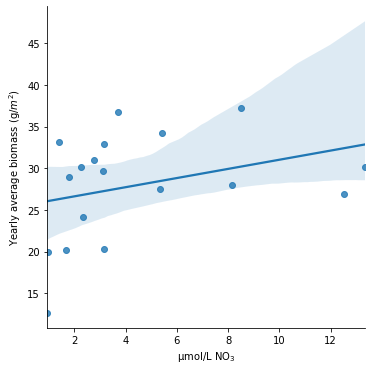

In [24]:
##summary statistics
df_means = df.groupby('EOYBYear', as_index = False).mean()
df_sem = df.groupby('EOYBYear').sem()

df_means['Year'] = df_means['EOYBYear']
#df.groupby('EOYBYear').aggregate([np.mean, np.size])
df_means ##'average lat/long' useless

list(df_means)
mn_mass = df_means[['Year', 'liveMass']]
mn_mass
xxx = pd.merge(mn_mass, no3, on='Year')
xxx

g = sns.lmplot(x = 'no3_no2', y = 'liveMass', ci = 95, data = xxx)
g.set_axis_labels("µmol/L NO$_3$", "Yearly average biomass (g/$m^2$)")

##nitrate/nitrite units: micromols per Liter


In [5]:
result = sm.ols(formula="liveMass ~ no3_no2", data = xxx).fit()
print(result.params)
print(result.summary()) ##no sig relationship - due to small sample size?

xxx['liveMass'].corr(xxx['no3_no2'], method = 'pearson')

Intercept    25.533419
no3_no2       0.549470
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               liveMass   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1.824
Date:                Wed, 28 Apr 2021   Prob (F-statistic):              0.196
Time:                        10:49:09   Log-Likelihood:                -57.701
No. Observations:                  18   AIC:                             119.4
Df Residuals:                      16   BIC:                             121.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/Users/asariversjulien/PhD/venv/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


0.3199222514980952

In [6]:
#df_sem

In [7]:
##grouped by site and by year
mn_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).aggregate([np.mean, np.size]).reset_index()
se_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).sem()

##rearrange lat and long for GEE
mn_siteyears = mn_siteyears[['siteName', 'EOYBYear', 'marshRegion', 'liveMass', 'longitude', \
                             'latitude', 'deadMass', 'totalMass']]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(mn_siteyears)
    
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'outx2.csv')
#se_siteyears.to_csv(out_csv, index=False) ##set out directory


In [8]:
#print(se_siteyears)

In [9]:
##some figures
#df.boxplot(column='liveMass', by='EOYBYear')
#mn_siteyears.boxplot(column='liveMass', by='siteName') ##using averages as individual points

In [10]:
##data analysis with cloud-masked data
masked_ndvi = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/masked_ndvi.csv')
masked_ndvi['EOYBYear'] = pd.to_datetime(masked_ndvi['EOYBYear'], format = '%Y')
masked_ndvi['imagedate'] = pd.to_datetime(masked_ndvi['imagedate'], format = '%m/%d/%y')
masked_ndvi['year'] = pd.DatetimeIndex(pd.to_datetime(round(masked_ndvi['year']), format = '%Y')).year

masked_ndvi = masked_ndvi[masked_ndvi['ndvi'] > 0] ##Gets rid of obviously flooded pixels and NA values

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
    print(masked_ndvi)

          siteName   EOYBYear   liveMass  liveMass.1    year  imagedate  \
0       Assateague 2000-01-01  11.100000          11  2000.0 2000-09-01   
1       Assateague 2001-01-01  25.415833          12  2001.0 2001-08-03   
8         Box_Tree 2000-01-01  38.183333           6  2000.0 2000-09-01   
9         Box_Tree 2001-01-01  59.606250           8  2001.0 2001-08-03   
10        Box_Tree 2002-01-01  29.087500          12  2002.0 2002-08-22   
12        Box_Tree 2004-01-01  30.342778          18  2004.0 2004-08-11   
14        Box_Tree 2007-01-01  23.378125          16  2007.0 2007-08-04   
16        Box_Tree 2009-01-01  27.724167          12  2009.0 2009-08-09   
18        Box_Tree 2011-01-01  21.977222          18  2011.0 2011-08-15   
19        Box_Tree 2012-01-01  31.903077          13  2012.0 2012-09-26   
20        Box_Tree 2013-01-01  24.810714          14  2013.0 2013-09-05   
22        Box_Tree 2015-01-01  20.482000          15  2015.0 2015-09-27   
23        Box_Tree 2016-0

In [52]:
##Training and testing biomass ~ ndvi: getting datasets
#train, test = train_test_split(masked_ndvi, test_size = 0.3) ##have to redo next chunk every time you run this


Intercept    17.937153
ndvi         22.953208
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               liveMass   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     4.701
Date:                Wed, 28 Apr 2021   Prob (F-statistic):             0.0336
Time:                        12:35:32   Log-Likelihood:                -262.70
No. Observations:                  70   AIC:                             529.4
Df Residuals:                      68   BIC:                             533.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

<ipython-input-66-e1599d91e8da>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = 22.95 * test['ndvi'] + 17.93


10.829449330113656

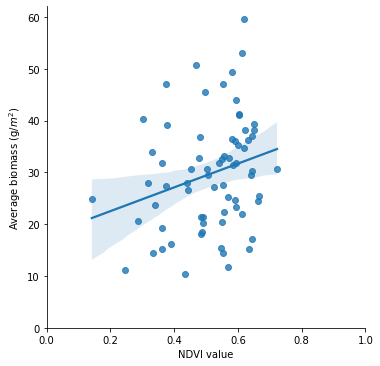

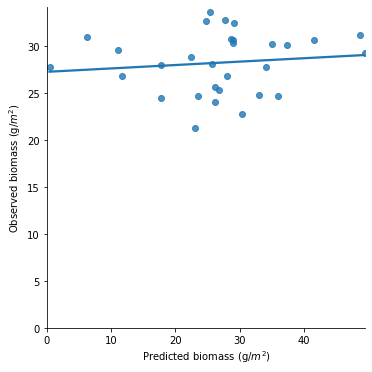

In [66]:
##Training and testing biomass ~ ndvi
result = sm.ols(formula="liveMass ~ ndvi", data = train).fit() #mass = 22.95 * ndvi + 17.93
print(result.params)
print(result.summary())

g = sns.lmplot(x = "ndvi", y = "liveMass", ci = 95, data=train) ##CI seems a little too small?
g.set_axis_labels("NDVI value", "Average biomass (g/$m^2$)")
g.set(ylim=(0, None), xlim=(0, 1))

test['predicted'] = 22.95 * test['ndvi'] + 17.93
x = sns.lmplot(x = "liveMass", y = "predicted", ci = 1, data=test)
x.set_axis_labels("Predicted biomass (g/$m^2$)", "Observed biomass (g/$m^2$)")
x.set(ylim=(0, None), xlim=(0, None))

actual = test['liveMass']
predicted = test['predicted']

mse = sklearn.metrics.mean_squared_error(actual, predicted)
sqrt(mse)

0.23069209766255905

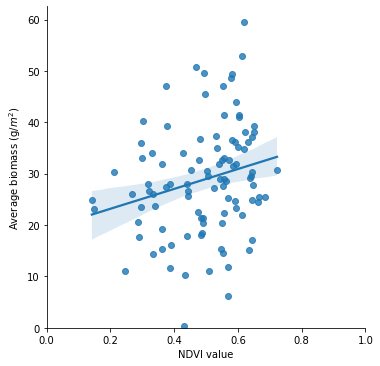

In [71]:
##Plots

g = sns.lmplot(x = "ndvi", y = "liveMass", ci = 95, data=masked_ndvi) ##CI seems a little too small?
g.set_axis_labels("NDVI value", "Average biomass (g/$m^2$)")
g.set(ylim=(0, None), xlim=(0, 1))

masked_ndvi['ndvi'].corr(masked_ndvi['liveMass'], method = 'pearson')

#my_path = os.path.abspath('/Users/asariversjulien/Documents/Georgia/Project')
#my_file = 'p1.png'
#g.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')

##FLOODED PLOTS. something to consider with image collection that you have
##Error bars???

In [12]:
result = sm.ols(formula="liveMass ~ ndvi", data = masked_ndvi).fit()
print(result.params)
print(result.summary())

Intercept    19.298030
ndvi         19.349946
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               liveMass   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     5.509
Date:                Wed, 28 Apr 2021   Prob (F-statistic):             0.0209
Time:                        10:49:24   Log-Likelihood:                -376.61
No. Observations:                 100   AIC:                             757.2
Df Residuals:                      98   BIC:                             762.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

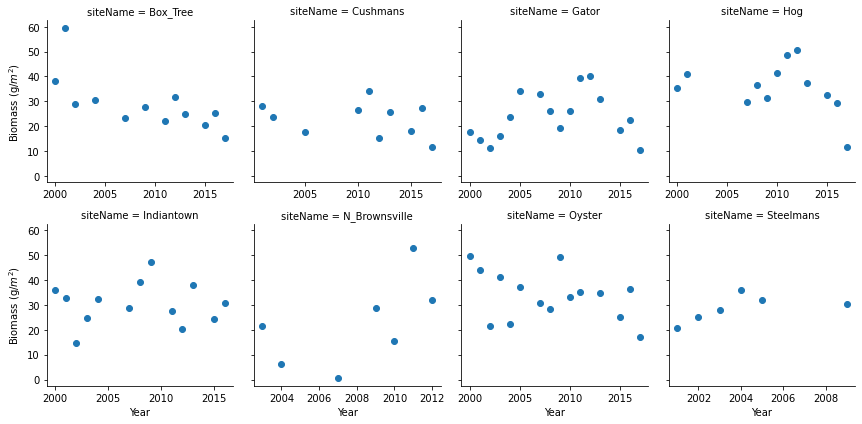

In [70]:
site_list = ['Box_Tree', 'Cushmans', 'Gator', 'Hog', 'Indiantown', 'N_Brownsville', 'Oyster', 'Steelmans']
df2 = masked_ndvi[masked_ndvi['siteName'].isin(site_list)]
g = sns.FacetGrid(df2, col="siteName", col_wrap=4,  sharex=False)
#g = sns.FacetGrid(masked_ndvi[masked_ndvi['siteName'] == 'Box_Tree'], col="siteName",  sharex=False)
g = g.map(plt.scatter, 'year', 'liveMass') ##interesting patterns here!!
g.set_axis_labels("Year", "Biomass (g/$m^2$)")
##Boxtree/Cushmans/Hog/Oyster = steady decrease in biomass over time
##Gator cyclical. Steelmans the only site that increased, but low N


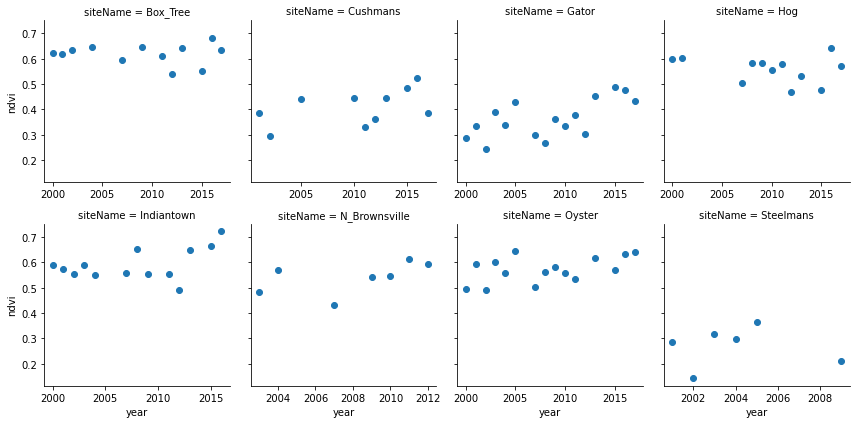

In [69]:
x_x = sns.FacetGrid(df2, col="siteName", col_wrap=4,  sharex=False)
g_x = x_x.map(plt.scatter, 'year', 'ndvi')

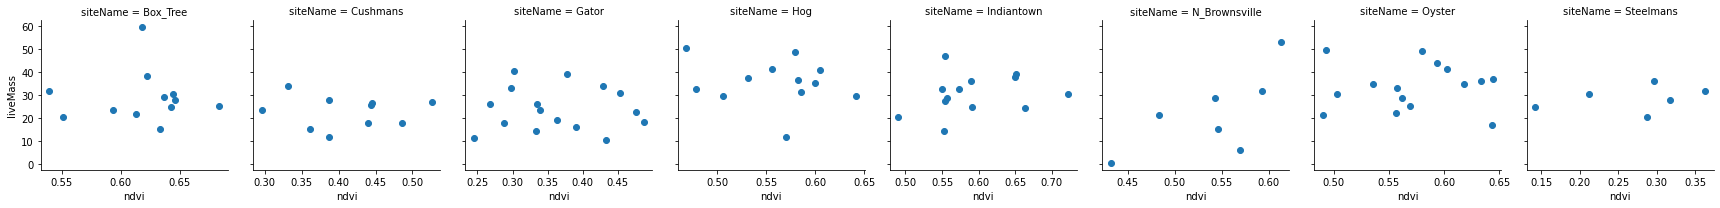

In [15]:
y_y = sns.FacetGrid(df2, col="siteName",  sharex=False) ##the way I'm doing things, ndvi bad predictor!!
g_y = y_y.map(plt.scatter, 'ndvi', 'liveMass')

In [25]:
##training/testing datasets!!! not really worth doing?

hi


In [26]:
print("hi")

hi
